# Common concepts

In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import numpy as np
import xplt

np.random.seed(4873153)

xplt.apply_style()

xplt.mpl.rcParams["figure.figsize"] = (3, 2)

In [2]:
data = xplt.util.AttrDict(
    label="Data A",
    x=1e-3 * np.random.normal(size=10000),
    y=2e-3 * (0.5 + np.random.normal(size=10000)),
)
data2 = xplt.util.AttrDict(
    label="Data B",
    x=2e-3 + 3 * data.x,
    y=data.y / 2 - 3e-3,
)

## Creating plots

All plotting classes share a common API as they are derived either from the base class {class}`XPlot <xplt.base.XPlot>` or {class}`XManifoldPlot <xplt.base.XManifoldPlot>`. In the following we will use the {class}`ParticleHistogramPlot <xplt.particles.ParticleHistogramPlot>` to demonstrate the common concepts.

To quickly create a plot, simply instanciate it and provide the data:

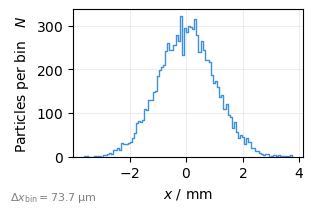

In [3]:
plot = xplt.ParticleHistogramPlot("x", particles=data)

The only mandatory parameter is the property to be plotted (`"x"`). Most plots also accept a `kind=` parameter to plot different properties on subplots or twin axes.
The data provided must contain or be suited to derive the requested properties. See below for a detailed description of properties, units and labels.

Most plots allso accept a `mask=` parameter to consider only a subset of the data:

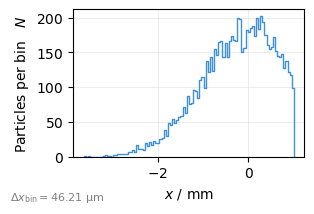

In [4]:
plot = xplt.ParticleHistogramPlot("x", particles=data, mask=data.x < 1e-3)

### Updating plot data

Plots can also be created blank, and the data updated later. This is very useful to create animations (see {doc}`/examples/animations`):

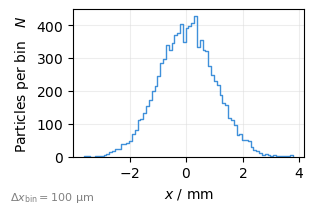

In [5]:
plot = xplt.ParticleHistogramPlot(
    "x", bin_width=1e-4, plot_kwargs=dict(label="Data A")
)
plot.update(data);

The parameter `plot_kwargs=` always allows to customize the artist.
You can add more datasets:

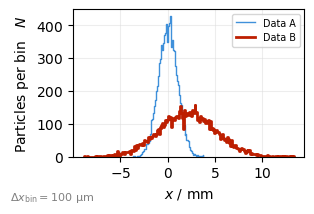

In [6]:
plot.add_dataset(
    "ref",  # optional ID to update data later
    particles=data2,
    plot_kwargs=dict(label="Data B", c="C2", lw=2),
    autoscale=True,
)
plot.fig

...and update them as needed:

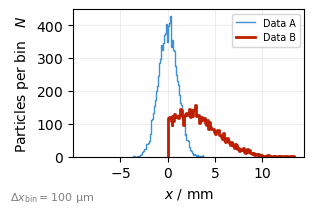

In [7]:
plot.update(data2, mask=data2.x > 0, dataset_id="ref")
plot.fig

```{tip}
To add multiple datasets in a loop, pass `add_default_dataset=False` to the constructor to avoid the default artists from being created for you.
```

The parameter `autoscale=` of the {meth}`xplt.ParticleHistogramPlot.add_dataset` and {meth}`xplt.ParticleHistogramPlot.update` methods allows to specify the autoscale behaviour. By default, autoscaling is only performed on the first time data is supplied to the plot.  
You can also manually autoscale the plot anytime:

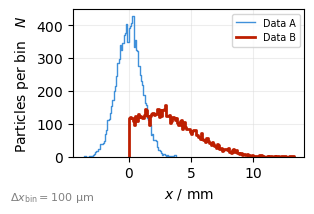

In [8]:
plot.autoscale(axis="x", tight=False, reset=True)
plot.fig

### Composing plots

By passing an existing axis to the constructor, it is possible to create composed plots (the axis shape must match the one otherwise created by the plot):

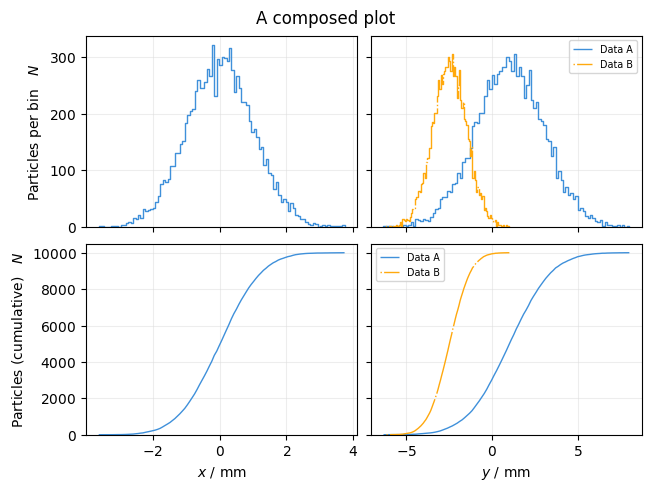

In [9]:
xplt.mpl.rcParams["figure.figsize"] = (6.4, 4.8)

fig, axs = plt.subplots(2, 2, sharex="col", sharey="row")
fig.suptitle("A composed plot")

for i, p in enumerate("xy"):
    for j, dat in enumerate((data, data2)):
        plot = xplt.ParticleHistogramPlot(
            p,
            dat,
            "count,cumulative",
            ax=axs[:, i],
            plot_kwargs=dict(label=dat.label, ls=f"-{j}"),  # customization
        )
        if i == 0:
            break

for a in axs[:, 1]:
    a.set(ylabel=None)

## Properties, Units and Labels

Properties are what makes this library easy to use while still very flexible.

A property is anything that we can "get" from a dataset, either as an attribute `data.xyz`, an index `data["xyz"]` or even a column in a pandas dataframe.  
For brevity, consider the following arbitrary dataset in the following:

In [10]:
# custom data
N = 10000
data = {
    "h": np.linspace(0, 100, num=N),
    "w": np.random.normal(size=N),
    "x": np.random.normal(size=N),
    "y": np.random.normal(size=N),
}

Now we can plot the x-y-phasespace simply by specifying exactly that:

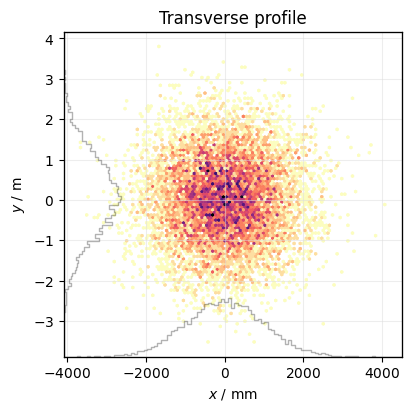

In [11]:
plot = xplt.PhaseSpacePlot(data, "x-y", display_units=dict(y="m"))

This works, because both `x` and `y` are standard properties which are defined in the library with default settings for units, labels and symbols.
Here specifically, the assumption is that `x` is provided in meters since that is the SI unit used by [Xsuite](https://xsuite.readthedocs.io), and that the default display unit for `x` should be millimeters. You can specify a display unit, and the data is automatically converted accordingly.

See below for a list of predefined properties and the default assumed. You can add or change properties and their respective units, labels and symbols if required.
Futher, derived properties can easily be defined building on the already existing ones.

### Adding custom data properties

To define or overwrite properties of a data object with a certain unit or meaning, you can either register them globally:

In [12]:
# our data["w"] is the width in km
xplt.register_data_property("w", data_unit="km", symbol="$w_x$", description="Width")

Or on-the-fly for a single plot with the `data_units` parameter.
Both enable automatic axes and legend labeling, as well as the use of the `display_units` parameter:

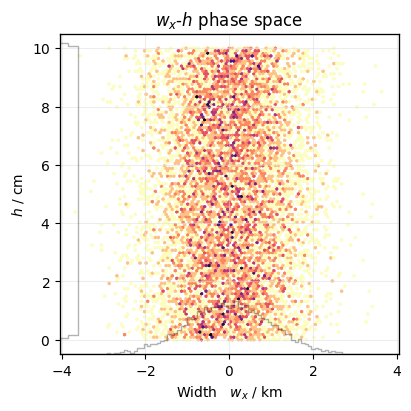

In [13]:
# our data["h"] is in mm, but we want to convert it to cm
plot = xplt.PhaseSpacePlot(
    data, "w-h", data_units={"h": "mm"}, display_units={"h": "cm"}
)

### Derived properties

It is often useful to add properties that depend on already existing ones,
e.g. if you simply want to plot the squareroot of a parameter, or have a complex expression.
The function parameters must be valid property names, such that the data and units can be inferred automatically.
It is also possible to specify the unit explicitly where necessary.

In [14]:
# since both x and y are know properties (in meter), A is known to be in square meter
xplt.register_derived_property("A", lambda x, y: x * y, description="Area")
# since the unit of `6` can not be inferred, we declare B to be in square meter too
xplt.register_derived_property("B", lambda A: A + 6, unit="m^2")

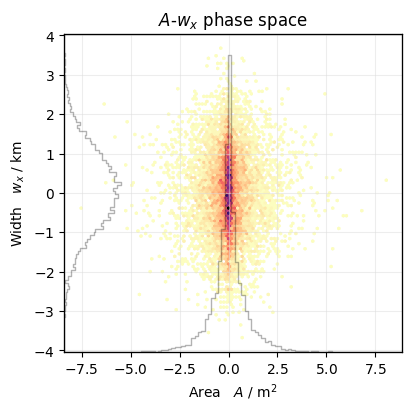

In [15]:
plot = xplt.PhaseSpacePlot(data, "A-w")

### Default properties

Global default properties applicable to all plots:

In [16]:
from IPython.display import display, Markdown
import pandas
import pint


def get_subclass_names(classname):
    all = {classname.__name__: classname}
    for subclassname in classname.__subclasses__():
        all.update(get_subclass_names(subclassname))
    return all


def display_class_info(cls):
    md = "Additional default properties applicable only to:"
    for name, c in sorted(get_subclass_names(cls).items()):
        if name.endswith("Plot") and not ".. deprecated::" in c.__doc__:
            md += f" {{class}}`{name} <{c.__module__}.{c.__qualname__}>`\n"
    display(Markdown(md))


def display_property_info(properties):
    der = np.any(
        [isinstance(p, xplt.properties.DerivedProperty) for p in properties.values()]
    )
    df = pandas.DataFrame(columns=["Unit", "Symbol", "Description", "Derived from"])
    df.index.name = "Property"
    for p, prop in sorted(properties.items()):
        df.loc[f"`{p}`"] = [
            f"$ {pint.Unit(prop.unit):~#L} $",
            prop.symbol,
            prop.description or "",
            (
                f"`{'` `'.join(prop.evaluate.__code__.co_varnames)}`"
                if isinstance(prop, xplt.properties.DerivedProperty)
                else ""
            ),
        ]
    # https://github.com/jupyter-book/jupyter-book/issues/1501#issuecomment-2301641068
    display(Markdown(df.to_markdown()))


display_property_info(xplt.properties._default_properties)

| Property       | Unit                                   | Symbol                                  | Description                 | Derived from                 |
|:---------------|:---------------------------------------|:----------------------------------------|:----------------------------|:-----------------------------|
| `at_turn`      | $  $                                   | $n$                                     | Turn                        |                              |
| `charge_ratio` | $  $                                   | $q/q_\mathrm{ref}$                      | Charge ratio                |                              |
| `chi`          | $  $                                   | $(q/q_\mathrm{ref})/(m/m_\mathrm{ref})$ | Charge-over-rest-mass ratio |                              |
| `count`        | $  $                                   | $N$                                     | Count                       |                              |
| `delta`        | $  $                                   | $\delta$                                |                             |                              |
| `energy`       | $ \mathrm{eV} $                        | $E$                                     | Total energy                |                              |
| `m`            | $ \frac{\mathrm{eV}}{\mathrm{c}^{2}} $ | $m$                                     | Rest mass                   | `chi` `charge_ratio` `mass0` |
| `mass0`        | $ \frac{\mathrm{eV}}{\mathrm{c}^{2}} $ | $m_\mathrm{ref}$                        | Reference rest mass         |                              |
| `ptau`         | $  $                                   | $p_\tau$                                |                             |                              |
| `px`           | $  $                                   | $x'$                                    |                             |                              |
| `py`           | $  $                                   | $y'$                                    |                             |                              |
| `pzeta`        | $  $                                   | $p_\zeta$                               |                             |                              |
| `q`            | $ \mathrm{e} $                         | $q$                                     | Charge                      | `q0` `charge_ratio`          |
| `q0`           | $ \mathrm{e} $                         | $q_\mathrm{ref}$                        | Reference charge            |                              |
| `s`            | $ \mathrm{m} $                         | $s$                                     |                             |                              |
| `tau`          | $ \mathrm{m} $                         | $\tau$                                  |                             |                              |
| `x`            | $ \mathrm{m} $                         | $x$                                     |                             |                              |
| `x_mean`       | $ \mathrm{m} $                         | $\langle x \rangle$                     |                             |                              |
| `x_std`        | $ \mathrm{m} $                         | $\sigma_x$                              |                             |                              |
| `y`            | $ \mathrm{m} $                         | $y$                                     |                             |                              |
| `y_mean`       | $ \mathrm{m} $                         | $\langle y \rangle$                     |                             |                              |
| `y_std`        | $ \mathrm{m} $                         | $\sigma_y$                              |                             |                              |
| `zeta`         | $ \mathrm{m} $                         | $\zeta$                                 |                             |                              |

#### Particle plots

These plots support normalized coordinates and action-angle-variables.

See {doc}`/examples/phasespace` for usage examples

In [17]:
display_class_info(xplt.particles.ParticlePlotMixin)
display_property_info(
    xplt.particles.ParticlePlotMixin()._init_particle_mixin()["_properties"]
)

Additional default properties applicable only to: {class}`ParticleHistogramPlot <xplt.particles.ParticleHistogramPlot>`
 {class}`ParticlesPlot <xplt.particles.ParticlesPlot>`
 {class}`PhaseSpacePlot <xplt.phasespace.PhaseSpacePlot>`
 {class}`SpillQualityPlot <xplt.timestructure.SpillQualityPlot>`
 {class}`SpillQualityTimescalePlot <xplt.timestructure.SpillQualityTimescalePlot>`
 {class}`TimeBinPlot <xplt.timestructure.TimeBinPlot>`
 {class}`TimeFFTPlot <xplt.timestructure.TimeFFTPlot>`
 {class}`TimeIntervalPlot <xplt.timestructure.TimeIntervalPlot>`
 {class}`TimePlot <xplt.timestructure.TimePlot>`


| Property       | Unit                 | Symbol   | Description   | Derived from             |
|:---------------|:---------------------|:---------|:--------------|:-------------------------|
| `Jx`           | $ \mathrm{m} $       | $J_x$    |               | `X` `Px`                 |
| `Jy`           | $ \mathrm{m} $       | $J_y$    |               | `Y` `Py`                 |
| `Px`           | $ \mathrm{m}^{0.5} $ | $X'$     |               | `x` `px` `delta`         |
| `Py`           | $ \mathrm{m}^{0.5} $ | $Y'$     |               | `y` `py` `delta`         |
| `X`            | $ \mathrm{m}^{0.5} $ | $X$      |               | `x` `px` `delta`         |
| `Y`            | $ \mathrm{m}^{0.5} $ | $Y$      |               | `y` `py` `delta`         |
| `t`            | $ \mathrm{s} $       | $t$      |               | `_data` `at_turn` `zeta` |
| `zeta_wrapped` | $ \mathrm{m} $       | $\zeta$  |               | `zeta`                   |
| `Θx`           | $ \mathrm{rad} $     | $Θ_x$    |               | `X` `Px`                 |
| `Θy`           | $ \mathrm{rad} $     | $Θ_y$    |               | `Y` `Py`                 |

#### Histogram plots

In [18]:
display_class_info(xplt.particles.ParticleHistogramPlotMixin)
display_property_info(xplt.particles.ParticleHistogramPlotMixin()._init_particle_histogram_mixin()["_properties"])  # fmt: skip

Additional default properties applicable only to: {class}`ParticleHistogramPlot <xplt.particles.ParticleHistogramPlot>`
 {class}`TimeBinPlot <xplt.timestructure.TimeBinPlot>`
 {class}`TimeFFTPlot <xplt.timestructure.TimeFFTPlot>`
 {class}`TimeIntervalPlot <xplt.timestructure.TimeIntervalPlot>`


| Property     | Unit                              | Symbol    | Description            | Derived from   |
|:-------------|:----------------------------------|:----------|:-----------------------|:---------------|
| `charge`     | $ \mathrm{e} $                    | $Q$       | Charge per bin         |                |
| `count`      | $  $                              | $N$       | Particles per bin      |                |
| `cumulative` | $  $                              | $N$       | Particles (cumulative) |                |
| `current`    | $ \frac{\mathrm{e}}{\mathrm{s}} $ | $I$       | Current                |                |
| `rate`       | $ \frac{1}{\mathrm{s}} $          | $\dot{N}$ | Particle rate          |                |

#### Spill quality plots

In [19]:
display_class_info(xplt.timestructure.MetricesMixin)
display_property_info(xplt.timestructure.MetricesMixin._metric_properties)

Additional default properties applicable only to: {class}`SpillQualityPlot <xplt.timestructure.SpillQualityPlot>`
 {class}`SpillQualityTimescalePlot <xplt.timestructure.SpillQualityTimescalePlot>`


| Property   | Unit   | Symbol                                      | Description              | Derived from   |
|:-----------|:-------|:--------------------------------------------|:-------------------------|:---------------|
| `cv`       | $  $   | $c_\mathrm{v}=\sigma/\mu$                   | Coefficient of variation |                |
| `duty`     | $  $   | $F=\langle N \rangle^2/\langle N^2 \rangle$ | Spill duty factor        |                |
| `maxmean`  | $  $   | $M=\hat{N}/\langle N \rangle$               | Max-to-mean ratio        |                |

#### Floor plot

See {doc}`/examples/line` for usage examples

In [20]:
display_class_info(xplt.line.FloorPlot)
display_property_info(xplt.line.FloorPlot()._default_properties)
xplt.mpl.pyplot.close()

Additional default properties applicable only to: {class}`FloorPlot <xplt.line.FloorPlot>`


| Property   | Unit             | Symbol   | Description   | Derived from   |
|:-----------|:-----------------|:---------|:--------------|:---------------|
| `X`        | $ \mathrm{m} $   | $X$      |               |                |
| `Y`        | $ \mathrm{m} $   | $Y$      |               |                |
| `Z`        | $ \mathrm{m} $   | $Z$      |               |                |
| `phi`      | $ \mathrm{rad} $ | $\Phi$   |               |                |
| `psi`      | $ \mathrm{rad} $ | $\Psi$   |               |                |
| `theta`    | $ \mathrm{rad} $ | $\Theta$ |               |                |

#### Twiss plot

See {doc}`/examples/twiss` for usage examples

In [21]:
display_class_info(xplt.twiss.TwissPlot)
display_property_info(xplt.twiss.TwissPlot()._default_properties)
xplt.mpl.pyplot.close()

Additional default properties applicable only to: {class}`TwissPlot <xplt.twiss.TwissPlot>`


| Property      | Unit                     | Symbol             | Description   | Derived from   |
|:--------------|:-------------------------|:-------------------|:--------------|:---------------|
| `alfx`        | $  $                     | $\alpha_x$         |               |                |
| `alfy`        | $  $                     | $\alpha_y$         |               |                |
| `betx`        | $ \mathrm{m} $           | $\beta_x$          |               |                |
| `bety`        | $ \mathrm{m} $           | $\beta_y$          |               |                |
| `dpx`         | $  $                     | $D_{x'}$           |               |                |
| `dpy`         | $  $                     | $D_{y'}$           |               |                |
| `dx`          | $ \mathrm{m} $           | $D_x$              |               |                |
| `dy`          | $ \mathrm{m} $           | $D_y$              |               |                |
| `envelope3_x` | $ \mathrm{m} $           | $x\pm3\sigma_x$    |               | `x` `sigma_x`  |
| `envelope3_y` | $ \mathrm{m} $           | $y\pm3\sigma_y$    |               | `y` `sigma_y`  |
| `envelope_x`  | $ \mathrm{m} $           | $x\pm\sigma_x$     |               | `x` `sigma_x`  |
| `envelope_y`  | $ \mathrm{m} $           | $y\pm\sigma_y$     |               | `y` `sigma_y`  |
| `gamx`        | $ \frac{1}{\mathrm{m}} $ | $\gamma_x$         |               |                |
| `gamy`        | $ \frac{1}{\mathrm{m}} $ | $\gamma_y$         |               |                |
| `max_x`       | $ \mathrm{m} $           | $x_\mathrm{max}$   |               |                |
| `max_y`       | $ \mathrm{m} $           | $y_\mathrm{max}$   |               |                |
| `min_x`       | $ \mathrm{m} $           | $x_\mathrm{min}$   |               |                |
| `min_y`       | $ \mathrm{m} $           | $y_\mathrm{min}$   |               |                |
| `mux`         | $  $                     | $\mu_x$            |               |                |
| `muy`         | $  $                     | $\mu_y$            |               |                |
| `sigma_px`    | $  $                     | $\sigma_{x'}$      |               |                |
| `sigma_py`    | $  $                     | $\sigma_{y'}$      |               |                |
| `sigma_pzeta` | $  $                     | $\sigma_{p_\zeta}$ |               |                |
| `sigma_x`     | $ \mathrm{m} $           | $\sigma_x$         |               |                |
| `sigma_y`     | $ \mathrm{m} $           | $\sigma_y$         |               |                |
| `sigma_zeta`  | $ \mathrm{m} $           | $\sigma_\zeta$     |               |                |